In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "./data/coco_json/train/images/train.json", "./data/coco_json/train/images/")
register_coco_instances("my_dataset_val", {}, "./data/coco_json/val/images/val.json", "./data/coco_json/val/images/")
register_coco_instances("my_dataset_test", {}, "./data/coco_json/test/images/test.json", "./data/coco_json/test/images/")

In [3]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

WARNING [07/26 18:15:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/26 18:15:02 d2.data.datasets.coco]: Loaded 20 images in COCO format from ./detectron2/data/coco_json/train/images/train.json
WARNING [07/26 18:15:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/26 18:15:02 d2.data.datasets.coco]: Loaded 5 images in COCO format from ./detectron2/data/coco_json/val/images/val.json
WARNING [07/26 18:15:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/26 18:15:02 d2.data.datasets.coco]: Loaded 10 images in COCO format from ./detectron2/data/coco_json/test/images/test.json


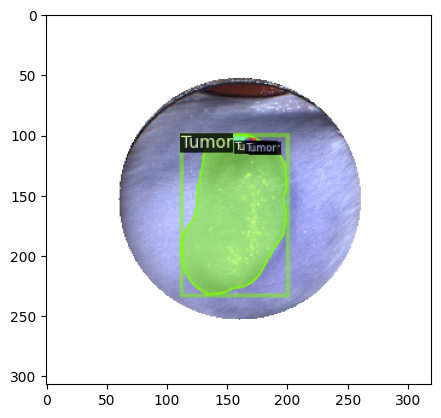

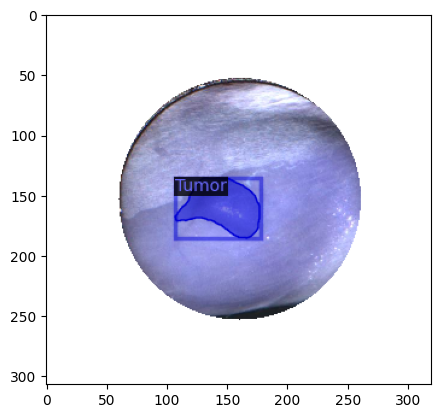

In [4]:
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
from detectron2.engine import DefaultTrainer

# this config was adapted from the detectron2 documentation for our purposes 

cfg = get_cfg()
# make sure to set output directory
cfg.OUTPUT_DIR = "./models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) 

[07/26 18:15:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [6]:
trainer.train()

[07/26 14:25:16 d2.engine.train_loop]: Starting training from iteration 0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/26 14:25:24 d2.utils.events]:  eta: 0:04:57  iter: 19  total_loss: 1.553  loss_cls: 0.5164  loss_box_reg: 0.1707  loss_mask: 0.6954  loss_rpn_cls: 0.1266  loss_rpn_loc: 0.02217    time: 0.3131  last_time: 0.3368  data_time: 0.0117  last_data_time: 0.0051   lr: 4.9953e-06  max_mem: 1870M
[07/26 14:25:30 d2.utils.events]:  eta: 0:04:51  iter: 39  total_loss: 1.449  loss_cls: 0.4355  loss_box_reg: 0.1768  loss_mask: 0.692  loss_rpn_cls: 0.0804  loss_rpn_loc: 0.01301    time: 0.3098  last_time: 0.2782  data_time: 0.0049  last_data_time: 0.0052   lr: 9.9902e-06  max_mem: 1873M
[07/26 14:25:37 d2.utils.events]:  eta: 0:04:49  iter: 59  total_loss: 1.355  loss_cls: 0.3284  loss_box_reg: 0.1584  loss_mask: 0.6851  loss_rpn_cls: 0.05743  loss_rpn_loc: 0.01349    time: 0.3146  last_time: 0.3562  data_time: 0.0051  last_data_time: 0.0088   lr: 1.4985e-05  max_mem: 1873M
[07/26 14:25:43 d2.utils.events]:  eta: 0:04:40  iter: 79  total_loss: 1.126  loss_cls: 0.1954  loss_box_reg: 0.04458  loss_

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/26 18:15:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/Detectron2_Models/model_final.pth ...


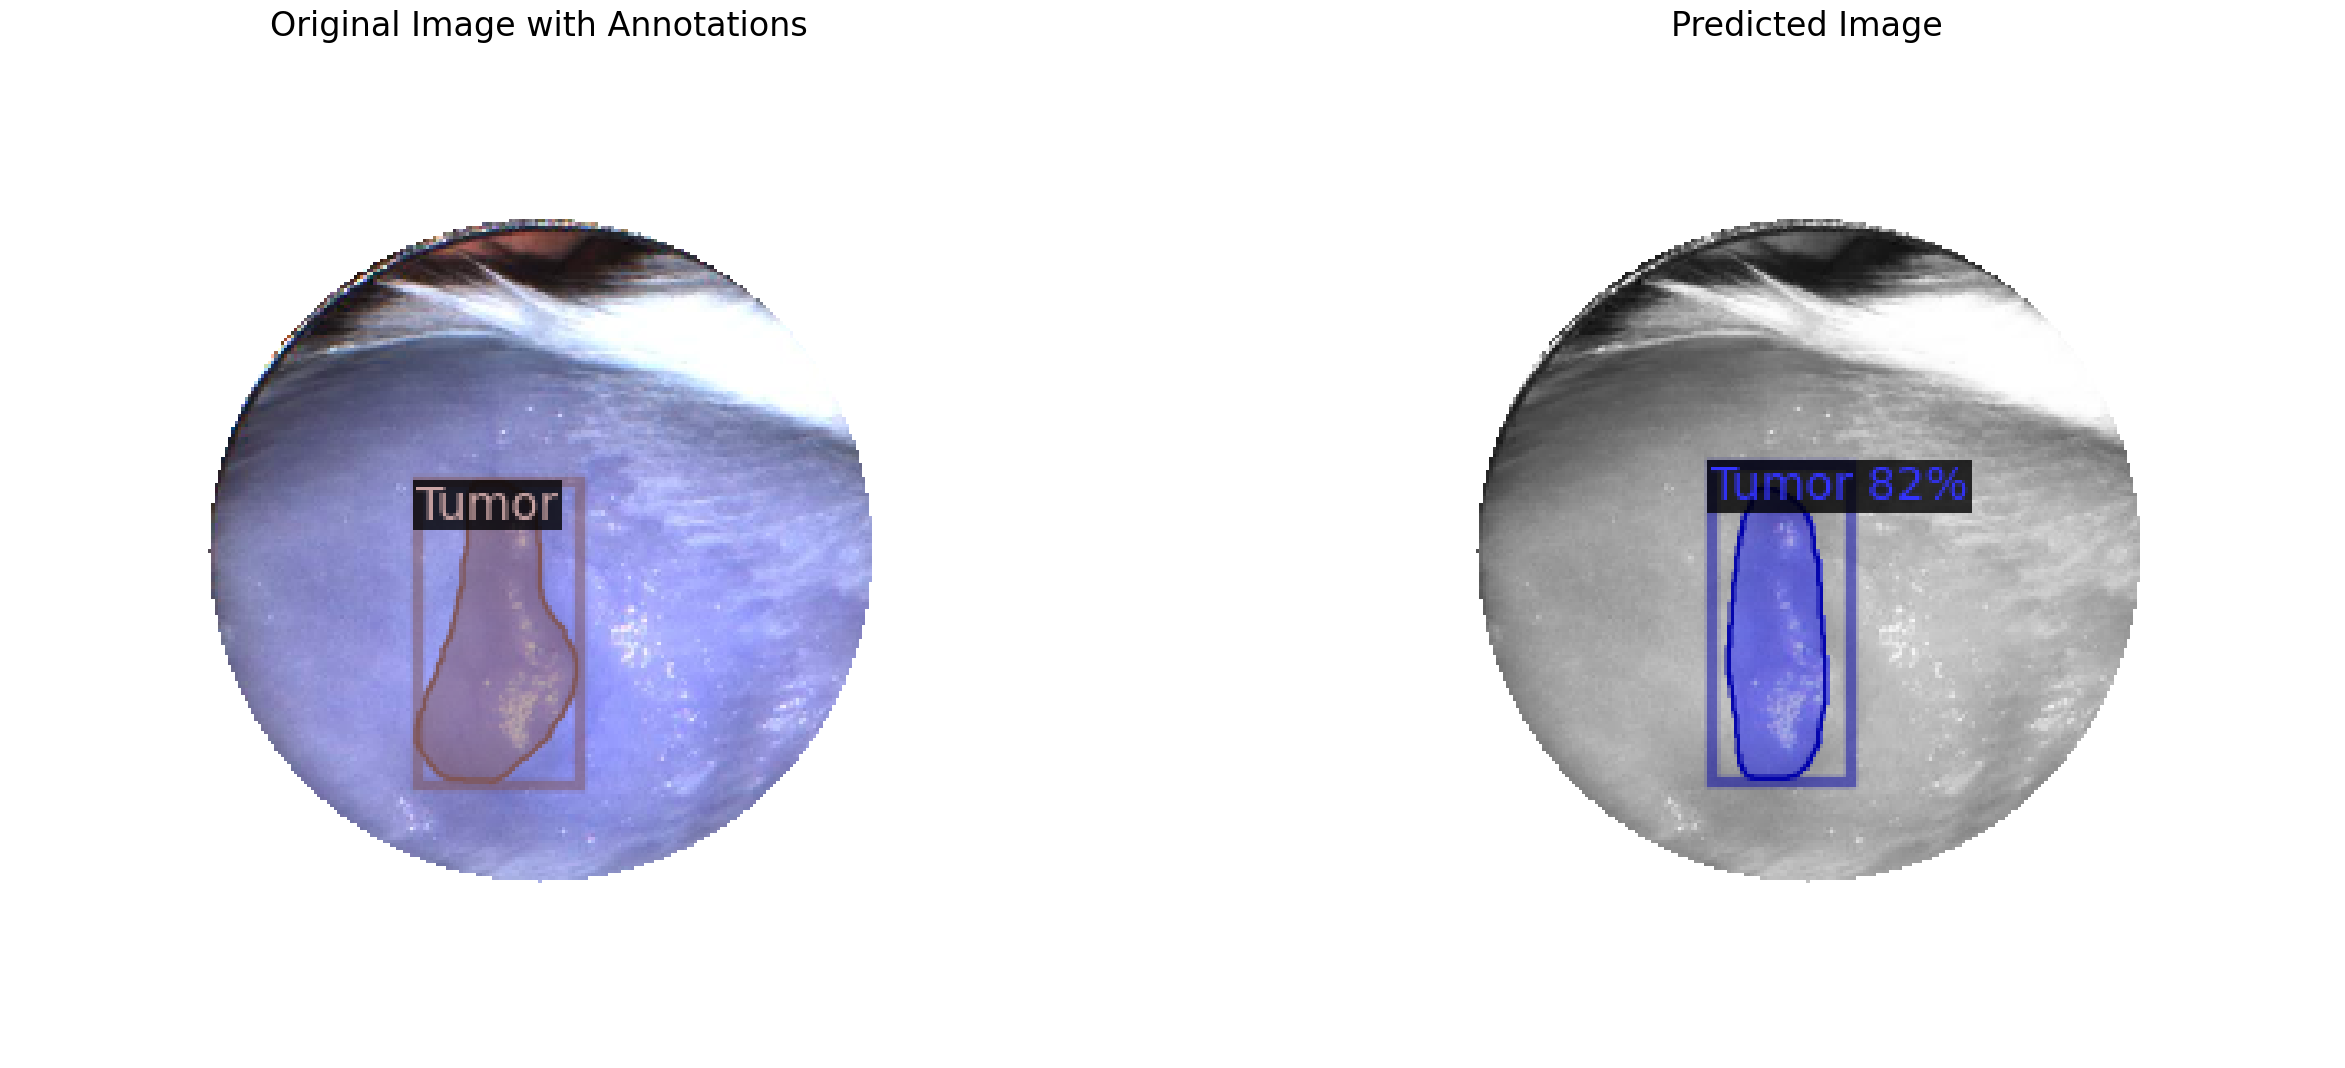

In [12]:


# Function to display the original image with annotations and the predicted image
def display_original_and_prediction_with_annotations(val_dataset_dicts, predictor, val_metadata):
    for d in random.sample(val_dataset_dicts, 1):  # Select number of images for display
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        # Create a visualizer object for the original image with annotations
        v_gt = Visualizer(im[:, :, ::-1],
                          metadata=val_metadata,
                          scale=0.5
        )
        out_gt = v_gt.draw_dataset_dict(d)
        
        # Create a visualizer object for the predicted image
        v_pred = Visualizer(im[:, :, ::-1],
                            metadata=val_metadata,
                            scale=0.5,
                            instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
        )
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Set up subplots
        fig, ax = plt.subplots(1, 2, figsize=(30, 30))
        
        # Display the original image with annotations
        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Original Image with Annotations', fontsize=24)
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Predicted Image', fontsize=24)

        for a in ax:
            a.axis("off")
        
        plt.show()

# Example usage
display_original_and_prediction_with_annotations(test_dataset_dicts, predictor, test_metadata)


In [15]:
def save_all_images(val_dataset_dicts, predictor, val_metadata, output_dir):
    
    #create image path if it doesnt exist 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, d in enumerate(val_dataset_dicts):

        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        v_gt = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5)
        out_gt = v_gt.draw_dataset_dict(d)
        
        v_pred = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        fig, ax = plt.subplots(1, 2, figsize=(30, 30))

        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Image with Original Annotations', fontsize=24)
        ax[0].axis('off')
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Images with Annotations produced by the model', fontsize=24)
        ax[1].axis('off')
        
        fig.savefig(os.path.join(output_dir, f"image_{i}.png"), bbox_inches="tight")
        plt.close(fig) 

In [16]:
save_all_images(test_dataset_dicts, predictor, test_metadata, './detectron2/images_rgb')